In [1]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from plotting import load_fits, plot_utils, summary_plots, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils


In [33]:
subject = 1
volume_space=True
fitting_type1 = 'alexnet_all_conv'
fitting_type2 = 'alexnet_all_conv'
# fitting_type1='texture_pyramid_ridge_4ori_4sf'
# fitting_type2='texture_pyramid_ridge_4ori_4sf'
# fitting_type2='texture_pyramid_ridge_4ori_4sf_pca_LL_pca_HL'

# fitting_type1 = 'sketch_tokens'
# fitting_type2 = 'sketch_tokens'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out1, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type1,\
                                                   n_from_end=3, root=root, verbose=True);
# load_fits.print_output_summary(out1)

out2, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type2, \
                                                   n_from_end=2, root=root, verbose=True);
# load_fits.print_output_summary(out2)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/alexnet_all_conv/Nov-01-2021_1424_05/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'fitting_type2', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'alexnet_layer_name'])
loading from /user_data/mmhender/imStat/model_fits/S01/alexnet_all_conv/Nov-01-2021_2240_40/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'fitting_type2', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'parti

In [35]:
out2['which_prf_grid']

3

In [65]:
out1['models'].shape

(875, 3)

In [37]:
out1['alexnet_padding_mode']

KeyError: 'alexnet_padding_mode'

In [38]:
fitting_type1 = 'zero-pad'
fitting_type2 = 'reflect-pad'
# fitting_type1 = 'rect-grid'
# fitting_type2 = 'polar-grid'
# fitting_type1 = 'rect grid'
# fitting_type2 = 'polar grid'


In [39]:
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 
skip_inds = [10,11,15,23]


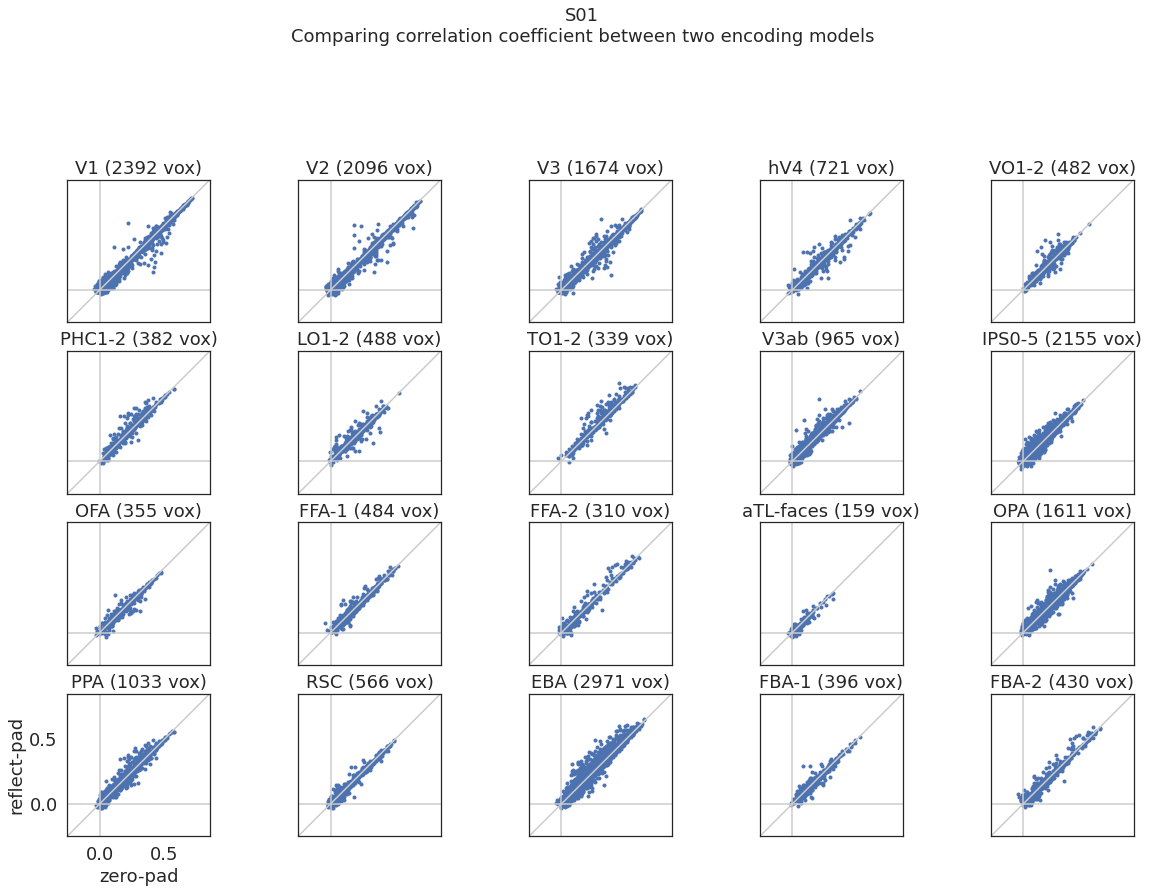

In [12]:
plot_utils.set_all_font_sizes(fs = 18)
cc_cutoff = 0.20
val_cc1 = out1['val_cc'][:,0:1]
val_cc2 = out2['val_cc'][:,0:1]
dat = np.concatenate((val_cc1,val_cc2), axis=1)

inds2use = np.ones([len(val_cc1),])==1

sp = plot_utils.scatter_plot(color=None, xlabel=fitting_type1, ylabel=fitting_type2, \
                             xlims=[-0.25, 0.85], ylims=[-0.25, 0.85], \
                  xticks=[0, 0.5], yticks=[0, 0.5],\
                  show_diagonal=True, show_axes=True);

plot_utils.create_roi_subplots(dat, inds2use, sp, subject, out1,\
                    suptitle='S%02d\nComparing correlation coefficient between two encoding models'%(subject), \
                   label_just_corner=True, figsize=(20,24), roi_def=roi_def, skip_inds=skip_inds)

plt.gcf().subplots_adjust(bottom=0.5)
# if fig_save_folder is not None:
#     plt.savefig(os.path.join(fig_save_folder,'scatter_%s_vs_%s_eachroi.pdf'%(fitting_type1, fitting_type2)))
#     plt.savefig(os.path.join(fig_save_folder,'scatter_%s_vs_%s_eachroi.png'%(fitting_type1, fitting_type2)))

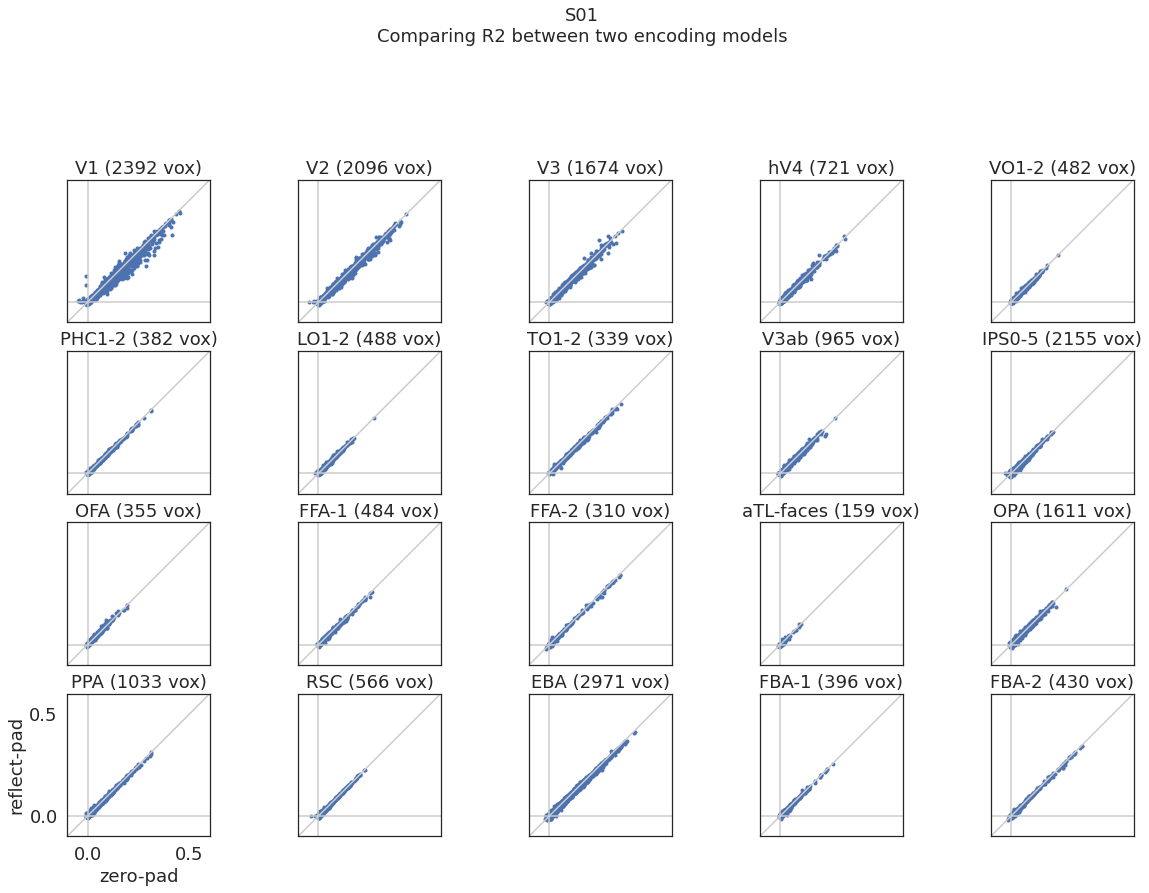

In [47]:
plot_utils.set_all_font_sizes(fs = 18)
cc_cutoff = 0.20
# val_rsq1 = out1['val_r2'][:,0:1]
# val_rsq2 = out2['val_r2'][:,0:1]
val_rsq1 = out1['val_r2'][:,9:10]
val_rsq2 = out2['val_r2'][:,9:10]
dat = np.concatenate((val_rsq1,val_rsq2), axis=1)

inds2use = np.ones([len(val_cc1),])==1

sp = plot_utils.scatter_plot(color=None, xlabel=fitting_type1, ylabel=fitting_type2, \
                             xlims=[-0.1, 0.6], ylims=[-0.1, 0.6], \
                  xticks=[0, 0.5], yticks=[0, 0.5],\
                  show_diagonal=True, show_axes=True);

plot_utils.create_roi_subplots(dat, inds2use, sp, subject, out1,\
                    suptitle='S%02d\nComparing R2 between two encoding models'%(subject), \
                   label_just_corner=True, figsize=(20,24),roi_def=roi_def, skip_inds=skip_inds)

plt.gcf().subplots_adjust(bottom=0.5)
# if fig_save_folder is not None:
#     plt.savefig(os.path.join(fig_save_folder,'scatter_%s_vs_%s_eachroi.pdf'%(fitting_type1, fitting_type2)))
#     plt.savefig(os.path.join(fig_save_folder,'scatter_%s_vs_%s_eachroi.png'%(fitting_type1, fitting_type2)))

In [31]:
out2['partial_version_names'][1]

'just_Conv1_ReLU'

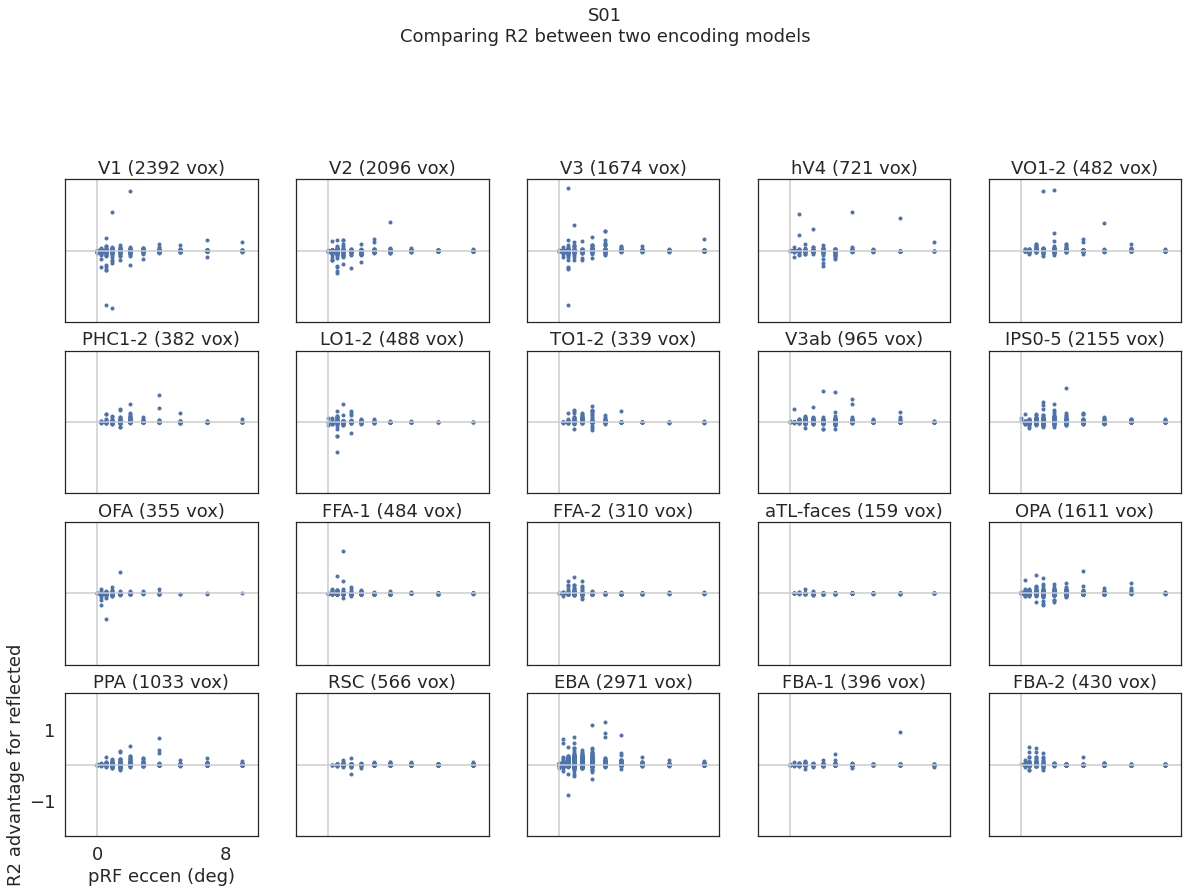

In [21]:
plot_utils.set_all_font_sizes(fs = 18)
cc_cutoff = 0.20
val_rsq1 = out1['val_r2'][:,0:1]
val_rsq2 = out2['val_r2'][:,0:1]

diff_r2 = val_rsq2-val_rsq1;

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out2, \
                                                                   screen_eccen_deg=8.4)

dat = np.concatenate((best_ecc_deg[:,np.newaxis],diff_r2), axis=1)

inds2use = np.ones([len(val_cc1),])==1

sp = plot_utils.scatter_plot(color=None, xlabel='pRF eccen (deg)', ylabel='R2 advantage for reflected', \
                             xlims=[-2,10], ylims=[-2, 2], \
                  xticks=[0,8], yticks=[-1, 1],\
                  show_diagonal=False, show_axes=True, square=False);

plot_utils.create_roi_subplots(dat, inds2use, sp, subject, out1,\
                    suptitle='S%02d\nComparing R2 between two encoding models'%(subject), \
                   label_just_corner=True, figsize=(20,24),roi_def=roi_def, skip_inds=skip_inds)

plt.gcf().subplots_adjust(bottom=0.5)
# if fig_save_folder is not None:
#     plt.savefig(os.path.join(fig_save_folder,'scatter_%s_vs_%s_eachroi.pdf'%(fitting_type1, fitting_type2)))
#     plt.savefig(os.path.join(fig_save_folder,'scatter_%s_vs_%s_eachroi.png'%(fitting_type1, fitting_type2)))

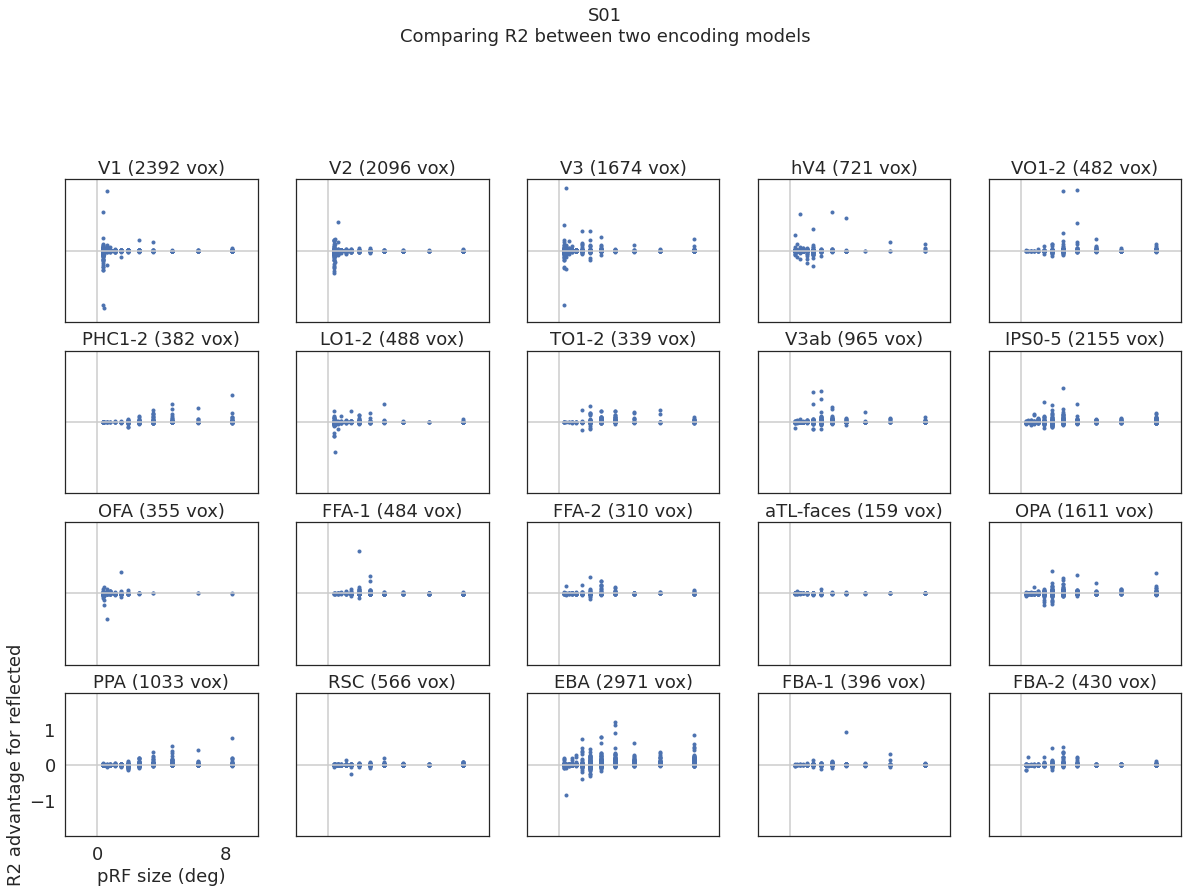

In [23]:
plot_utils.set_all_font_sizes(fs = 18)
cc_cutoff = 0.20
val_rsq1 = out1['val_r2'][:,0:1]
val_rsq2 = out2['val_r2'][:,0:1]

diff_r2 = val_rsq2-val_rsq1;

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out2, \
                                                                   screen_eccen_deg=8.4)

dat = np.concatenate((best_size_deg[:,np.newaxis],diff_r2), axis=1)

inds2use = np.ones([len(val_cc1),])==1

sp = plot_utils.scatter_plot(color=None, xlabel='pRF size (deg)', ylabel='R2 advantage for reflected', \
                             xlims=[-2,10], ylims=[-2, 2], \
                  xticks=[0,8], yticks=[-1,0,1],\
                  show_diagonal=False, show_axes=True, square=False);

plot_utils.create_roi_subplots(dat, inds2use, sp, subject, out1,\
                    suptitle='S%02d\nComparing R2 between two encoding models'%(subject), \
                   label_just_corner=True, figsize=(20,24),roi_def=roi_def, skip_inds=skip_inds)

plt.gcf().subplots_adjust(bottom=0.5)
# if fig_save_folder is not None:
#     plt.savefig(os.path.join(fig_save_folder,'scatter_%s_vs_%s_eachroi.pdf'%(fitting_type1, fitting_type2)))
#     plt.savefig(os.path.join(fig_save_folder,'scatter_%s_vs_%s_eachroi.png'%(fitting_type1, fitting_type2)))

In [28]:
np.min(diff_r2)

-2.7471783

In [21]:
best_ecc_deg.shape

(19738,)

In [3]:
from plotting_and_analysis import analysis_utils, spatial_fits
import copy

retlabs, catlabs, ret_group_names, categ_group_names = analysis_utils.get_combined_rois(subject, out1)
best_ecc_deg, best_angle_deg, best_size_deg = spatial_fits.get_prf_pars_deg(out1, screen_eccen_deg=8.4)

port=33333

names0 = ['pRF eccentricity', 'pRF angle', 'pRF size']
maps0 = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps0 = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins0 = [0,0,0]
maxes0 = [7, 360, 4]

names1 = ['R2: %s'%fitting_type1,'R2: %s'%fitting_type2, 'model w higher R2']

val_rsq1 = copy.deepcopy(out1['val_r2'][:,0:1])
val_rsq2 = copy.deepcopy(out2['val_r2'][:,0:1])
dat = np.concatenate((val_rsq1,val_rsq2), axis=1)

max_ind = (np.argmax(dat, axis=1)+1).astype(np.float32)

bad_voxels = np.squeeze((val_rsq1<0) &  (val_rsq2<0))
val_rsq1[bad_voxels] = np.nan
val_rsq2[bad_voxels] = np.nan
max_ind[bad_voxels] = np.nan
maps1 = [np.squeeze(np.sqrt(val_rsq1)), np.squeeze(np.sqrt(val_rsq2)), max_ind]

cmaps1 = ['PuBu', 'PuBu', 'plasma_r']
mins1 = [0, 0, 0, 0, 0] 
maxes1 = [0.6, 0.6, 2]

maps = maps0+maps1
cmaps=cmaps0+cmaps1
names=names0+names1
mins=mins0+mins1
maxes=maxes0+maxes1

plot_utils.plot_maps_pycortex(maps, names, subject, out1, fitting_type1, port, cmaps=cmaps, mins=mins, maxes=maxes)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333


In [10]:
np.sum(out1['voxel_roi'][0]==1)

1180

In [42]:
out1['best_params'][0][:,0,2]

array([0.55012482, 0.05816862, 0.12301165, ..., 0.0845897 , 0.37829664,
       0.26013798])

In [10]:
val_rsq1 = out1['val_r2'][:,0:1]
val_rsq2 = out2['val_r2'][:,0:1]
dat = np.concatenate((val_rsq1,val_rsq2), axis=1)

max_ind = (np.argmax(dat, axis=1)+1).astype(np.float32)


In [34]:
models1 = out1['best_params'][0][:,0,:]
models2 = out2['best_params'][0][:,0,:]

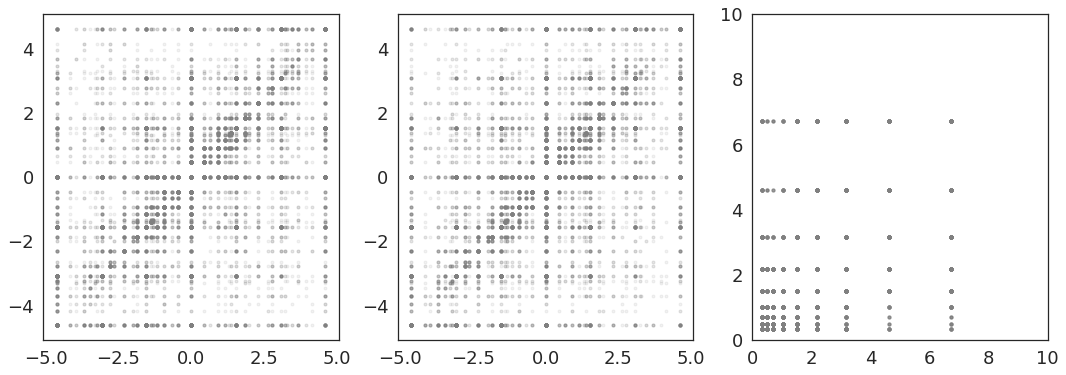

In [45]:
plt.figure(figsize=(18,6));
for ii in range(3):
    plt.subplot(1,3,ii+1)
    plt.plot(models1[:,ii]*8.4, models2[:,ii]*8.4,'.',color=[0.5, 0.5, 0.5, 0.1])
    if ii==2:
        plt.xlim([0,10])
        plt.ylim([0,10])